In [3]:
import os

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
url ='https://raw.githubusercontent.com/C4AnN/Models/main/dataset_processing%20(2)/filtered_data_low_level2.csv'
store_sales = pd.read_csv(url)
store_sales.head(10)

,name,price,date,sales
0,ASUS Vivobook A409FA- BV351T/BV352T,6850000,2013-06-03,12
1,ASUS VIVOBOOK A412FA I3-8145U 4GB 512GB SSD 14...,7999000,2013-06-04,15
2,ASUS VIVOBOOK M409BA-BV411T / M409BA-BV412T A4...,3989000,2013-06-05,24
3,ASUS VivoBook MAX X441BA - A9 9425/1TB/4GB/Rad...,4898000,2013-06-08,20
4,Notebook ASUS VivoBook MAX X441MA - Dual Core ...,4014000,2013-06-12,22
5,ASUS VIVOBOOK MAX X441UA - i3 7020U - 4GB - 1T...,5725000,2013-06-14,22
6,VIVOBOOK Asus S330FA-EY303T I3-8145U--SSD 256G...,7069000,2013-06-28,17
7,vivobook asus e203mah fd013t notebook petal pink,4900000,2013-06-29,20
8,Notebook Asus VivoBook E203-MAH - N4000|4GB|50...,3880000,2013-07-03,12
9,"ASUS VIVOBOOK K403FA I3-8145 4GB 512GB SSD 14""...",7899000,2013-07-08,20


In [6]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27065 entries, 0 to 27064
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    27065 non-null  object
 1   price   27065 non-null  int64 
 2   date    27065 non-null  object
 3   sales   27065 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 845.9+ KB


In [7]:
store_sales = store_sales.drop(['name','price'], axis=1)

In [8]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27065 entries, 0 to 27064
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    27065 non-null  object
 1   sales   27065 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 423.0+ KB


In [9]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [10]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27065 entries, 0 to 27064
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    27065 non-null  datetime64[ns]
 1   sales   27065 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 423.0 KB


In [11]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [12]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [13]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,7777
1,2013-02-01,7658
2,2013-03-01,10322
3,2013-04-01,11354
4,2013-05-01,12264
5,2013-06-01,15265
6,2013-07-01,19939
7,2013-08-01,13700
8,2013-09-01,12405
9,2013-10-01,13579


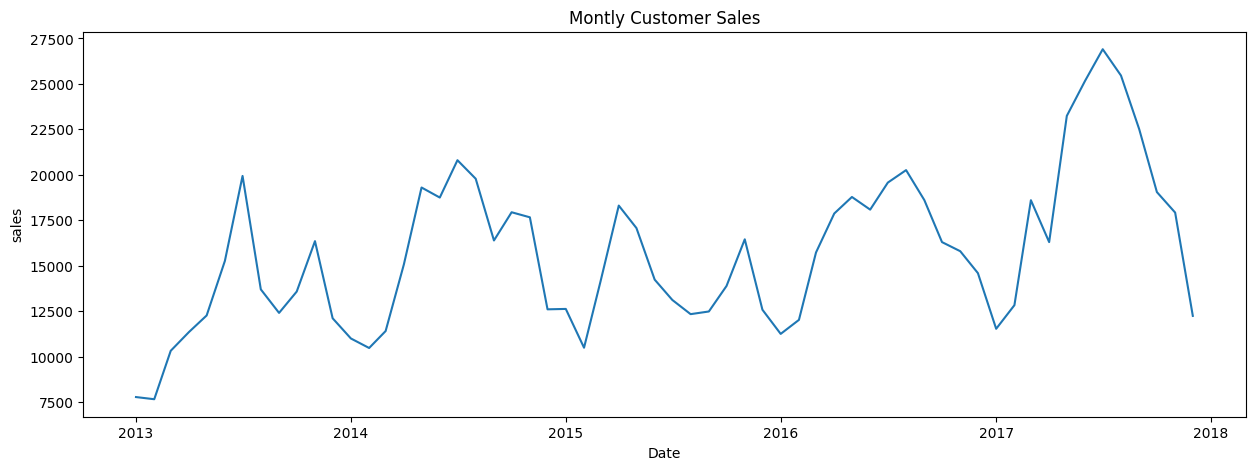

In [14]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly Customer Sales")
plt.show()

In [15]:
# Sales_diff = Selisih Total Penjualan Dengan Bulan Sebelumnya (Increase (+) atau Decrease (-) )
# Contoh Sales_diff pada Row 2 date 2013-03-01 didapatkan dari
# jumlah sales pada date 2013-03-01 (617382) - date 2013-02-01 (459417) didapatkan sales_diff = 157965.0

monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,7658,-119.0
2,2013-03-01,10322,2664.0
3,2013-04-01,11354,1032.0
4,2013-05-01,12264,910.0
5,2013-06-01,15265,3001.0
6,2013-07-01,19939,4674.0
7,2013-08-01,13700,-6239.0
8,2013-09-01,12405,-1295.0
9,2013-10-01,13579,1174.0
10,2013-11-01,16352,2773.0


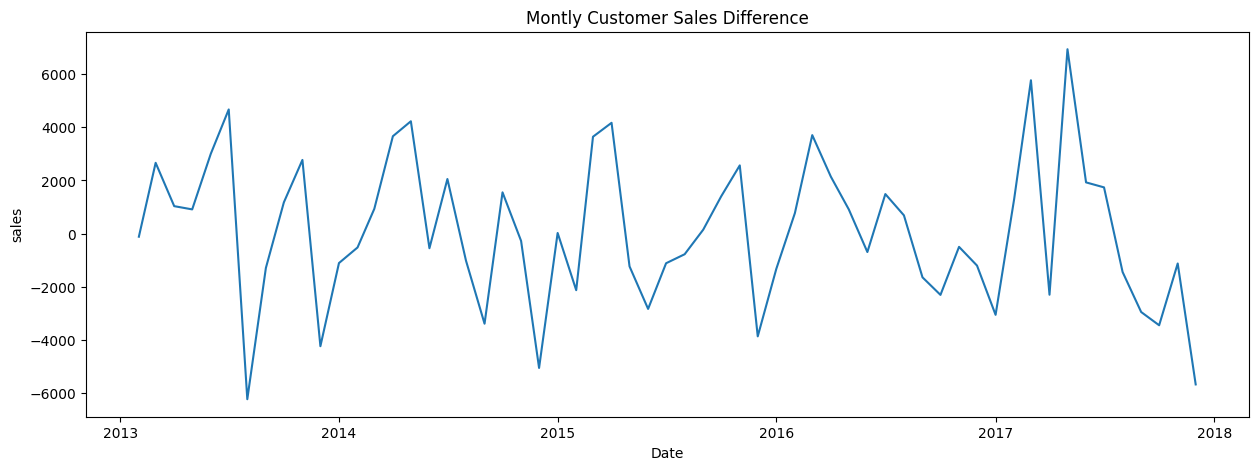

In [16]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly Customer Sales Difference")
plt.show()

In [17]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

In [18]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-524.0,-1111.0,-4242.0,2773.0,1174.0,-1295.0,-6239.0,4674.0,3001.0,910.0,1032.0,2664.0,-119.0
1,932.0,-524.0,-1111.0,-4242.0,2773.0,1174.0,-1295.0,-6239.0,4674.0,3001.0,910.0,1032.0,2664.0
2,3666.0,932.0,-524.0,-1111.0,-4242.0,2773.0,1174.0,-1295.0,-6239.0,4674.0,3001.0,910.0,1032.0
3,4229.0,3666.0,932.0,-524.0,-1111.0,-4242.0,2773.0,1174.0,-1295.0,-6239.0,4674.0,3001.0,910.0
4,-553.0,4229.0,3666.0,932.0,-524.0,-1111.0,-4242.0,2773.0,1174.0,-1295.0,-6239.0,4674.0,3001.0
5,2054.0,-553.0,4229.0,3666.0,932.0,-524.0,-1111.0,-4242.0,2773.0,1174.0,-1295.0,-6239.0,4674.0
6,-1019.0,2054.0,-553.0,4229.0,3666.0,932.0,-524.0,-1111.0,-4242.0,2773.0,1174.0,-1295.0,-6239.0
7,-3395.0,-1019.0,2054.0,-553.0,4229.0,3666.0,932.0,-524.0,-1111.0,-4242.0,2773.0,1174.0,-1295.0
8,1552.0,-3395.0,-1019.0,2054.0,-553.0,4229.0,3666.0,932.0,-524.0,-1111.0,-4242.0,2773.0,1174.0
9,-278.0,1552.0,-3395.0,-1019.0,2054.0,-553.0,4229.0,3666.0,932.0,-524.0,-1111.0,-4242.0,2773.0


In [19]:
# Previous 12 Month
train_data = supervised_data[:-12]
# The Coming 12 Month
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [20]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [21]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("x_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)

x_train shape :  (35, 12)
y_train shape :  (35,)
x_test shape :  (12, 12)
y_test shape :  (12,)


In [22]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [23]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[14592, 11531, 12830, 18603, 16299, 23241, 25168, 26907, 25459, 22504, 19050, 17923, 12241]


In [24]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [25]:
lr_pre = lr_pre.reshape(-1,1)
# This is a set matrix - contain the input features of the data, and also the predict output
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [26]:
result_list= []
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [27]:
# print(predict_df)
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linaer Regression MSE : ", lr_mse )
print("Linaer Regression MAE : ", lr_mae )
print("Linaer Regression R2 : ", lr_r2 )

Linaer Regression MSE :  3435.3222001434383
Linaer Regression MAE :  2819.5508623022815
Linaer Regression R2 :  0.43733046019582233


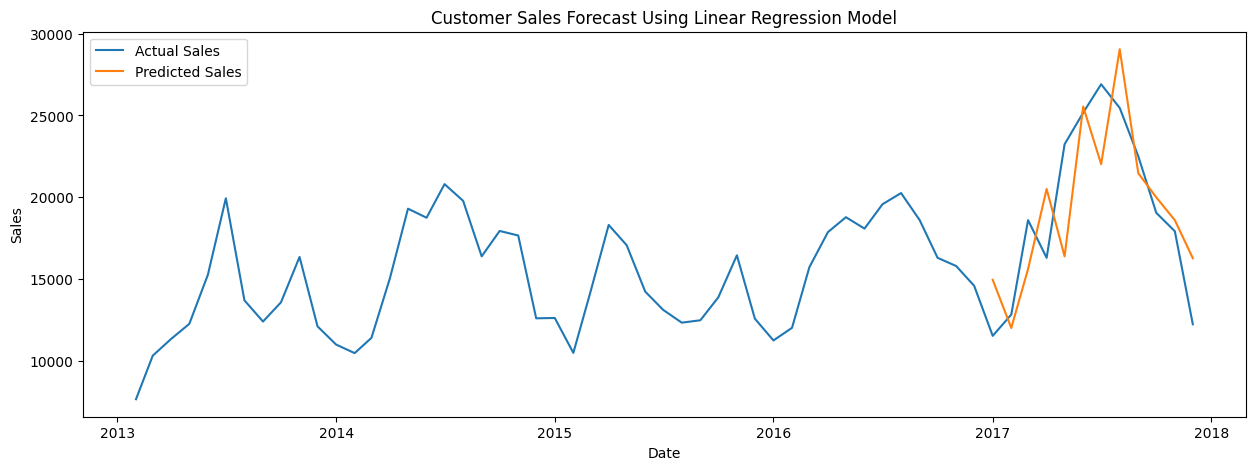

In [28]:
plt.figure(figsize=(15,5))
# Actual Sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer Sales Forecast Using Linear Regression Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()